<a href="https://colab.research.google.com/github/Druvith/NN_from_scratch2023/blob/main/vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      

In [2]:
%matplotlib inline
import torch
import torchvision
from torchvision.transforms import v2
from torch import nn
from d2l import torch as d2l

In [3]:
d2l.set_figsize()
img = d2l.Image.open('1.png')
d2l.plt.imshow(img);

FileNotFoundError: ignored

In [ ]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
  Y = [aug(img) for _ in range(num_rows * num_cols)]
  d2l.show_images(Y, num_rows, num_cols, scale = scale)

In [ ]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

In [ ]:
apply(img, torchvision.transforms.RandomVerticalFlip())

In [ ]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio = (0.5, 2))
apply(img, shape_aug)

In [ ]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0
))

In [ ]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

In [ ]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

In [ ]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug
])

apply(img, augs)

100%|██████████| 170498071/170498071 [00:05<00:00, 30103707.70it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

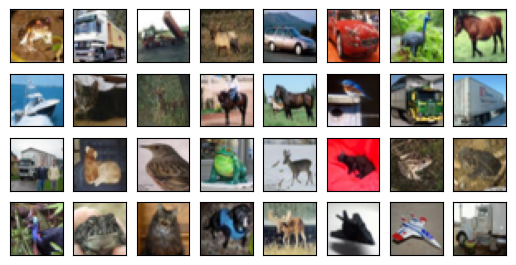

In [3]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [4]:
train_augs = v2.Compose([
    v2.RandomHorizontalFlip(), v2.ToTensor()
]) # we've used left and right flips and to tensor ops

test_augs = v2.Compose([
    v2.ToTensor()
]) # we haven't used image aug for eval

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
def load_cifar10(is_train, augs, batch_size):
  dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train, transform=augs, download=True)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers= d2l.get_dataloader_workers())
  return dataloader

In [6]:
#Multi-GPU Training (i've only one)

def train_batch_ch13(net, X, y, loss, trainer, devices):
  if isinstance(X, list):
    X = [x.to(devices[0] for x in X)]
  else:
    X = X.to(devices[0])
  y = y.to(devices[0])
  net.train()
  trainer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.sum().backward()
  trainer.step()
  trainer_loss_sum = l.sum()
  trainer_acc_sum = d2l.accuracy(pred, y)
  return trainer_loss_sum, trainer_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with multiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [7]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr = 0.001):
  train_iter = load_cifar10(True, train_augs, batch_size)
  test_iter = load_cifar10(False, test_augs, batch_size)
  loss = nn.CrossEntropyLoss(reduction='none')
  trainer = torch.optim.Adam(net.parameters(), lr=lr)
  net(next(iter(train_iter))[0])
  train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loss 0.215, train acc 0.926, test acc 0.845
1159.0 examples/sec on [device(type='cuda', index=0)]


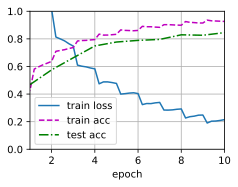

In [8]:
model = train_with_data_aug(train_augs, test_augs, net)

In [9]:
torch.save(model, 'cifar10.pth' )

In [11]:
model = torch.load('cifar10.pth')
model.

AttributeError: ignored